In [1]:
# Time Distribution Comparison - Data vs Predicted with True Parameters
# This notebook compares the time distribution from data with the predicted time distribution
# using the true track parameters to understand simulation accuracy

import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

# Import necessary modules
from tools.simulation import setup_event_simulator
from tools.geometry import generate_detector
from tools.utils import read_event_file, analyze_loaded_particle
from tools.visualization import create_detector_comparison_display

print("JAX devices:", jax.devices())
print("JAX version:", jax.__version__)

JAX devices: [CudaDevice(id=0)]
JAX version: 0.5.3


In [2]:
# Configuration and setup
json_filename = '../config/IWCD_geom_config.json'
Nphot = 500_000  # Higher photon count for better statistics

# Generate detector geometry
detector = generate_detector(json_filename)
detector_points = jnp.array(detector.all_points)
NUM_DETECTORS = len(detector_points)

print(f"Detector has {NUM_DETECTORS} PMTs")

# Setup event simulator
simulate_event = setup_event_simulator(json_filename, Nphot, K=5, is_data=False, temperature=0.)

# Detector parameters (same as used for data)
detector_params = (
    jnp.array(100),          # scatter_length
    jnp.array(0.05),         # reflection_rate
    jnp.array(100000.),      # absorption_length
    jnp.array(0.001)         # gumbel_softmax_temp
)

Detector has 9720 PMTs


In [3]:
# Load data event
data_filename = 'output/event_0.h5'
if not Path(data_filename).exists():
    print(f"Data file {data_filename} not found. Please create it first.")
    data_charges = None
    data_times = None
else:
    with h5py.File(data_filename, 'r') as f:
        data_charges = np.array(f['Q'])[0]
        data_times = np.array(f['T'])[0]
        true_mom = np.array(f['P'])[0]
        true_vtx = np.array(f['V'])[0]
        pdg_code = np.array(f['PDG'])[0]
    
    true_particle_info = analyze_loaded_particle(true_mom, true_vtx, pdg_code)
    
    print(f"True parameters:")
    print(f"  Energy: {true_particle_info['kinetic_energy']:.2f} MeV")
    print(f"  Position: [{true_particle_info['vertex'][0]:.3f}, {true_particle_info['vertex'][1]:.3f}, {true_particle_info['vertex'][2]:.3f}] m")
    print(f"  Angles: theta={np.degrees(true_particle_info['theta_rad']):.1f}°, phi={np.degrees(true_particle_info['phi_rad']):.1f}°")
    print(f"\nData statistics:")
    print(f"  Total charge: {np.sum(data_charges):.2f}")
    print(f"  PMTs with signal: {np.sum(data_charges > 0)}")
    print(f"  Mean time (active PMTs): {np.mean(data_times[data_times > 0]):.2f} ns")
    print(f"  Std time (active PMTs): {np.std(data_times[data_times > 0]):.2f} ns")

True parameters:
  Energy: 878.25 MeV
  Position: [0.068, -0.064, -0.055] m
  Angles: theta=50.4°, phi=6.8°

Data statistics:
  Total charge: 251118.11
  PMTs with signal: 8711
  Mean time (active PMTs): 3.99 ns
  Std time (active PMTs): 2.72 ns


In [4]:
# Simulate event using true parameters
if data_charges is not None:
    # Extract true parameters
    true_energy = jnp.array(true_particle_info['kinetic_energy'])
    true_position = jnp.array(true_particle_info['vertex'])
    true_angles = jnp.array([true_particle_info['theta_rad'], true_particle_info['phi_rad']])
    true_params = (true_energy, true_position, true_angles)
    
    # Run multiple simulations to get better statistics
    n_simulations = 1
    print(f"Running {n_simulations} simulations with true parameters...")
    
    all_sim_charges = []
    all_sim_times = []
    
    for i in range(n_simulations):
        key = jax.random.PRNGKey(42 + i)
        sim_charges, sim_times = simulate_event(true_params, detector_params, key)
        all_sim_charges.append(sim_charges)
        all_sim_times.append(sim_times)
        print(f"  Simulation {i+1}/{n_simulations} completed")
    
    # Average the simulations
    avg_sim_charges = jnp.mean(jnp.stack(all_sim_charges), axis=0)
    avg_sim_times = jnp.mean(jnp.stack(all_sim_times), axis=0)
    
    print(f"\nSimulation statistics (averaged over {n_simulations} runs):")
    print(f"  Total charge: {np.sum(avg_sim_charges):.2f}")
    print(f"  PMTs with signal: {np.sum(avg_sim_charges > 0.1)}")
    print(f"  Mean time (active PMTs): {np.mean(avg_sim_times[avg_sim_times > 0]):.2f} ns")
    print(f"  Std time (active PMTs): {np.std(avg_sim_times[avg_sim_times > 0]):.2f} ns")

Running 1 simulations with true parameters...
  Simulation 1/1 completed

Simulation statistics (averaged over 1 runs):
  Total charge: 257996.31
  PMTs with signal: 9719
  Mean time (active PMTs): 7.21 ns
  Std time (active PMTs): 2.73 ns


In [5]:
# Extract active PMT times for comparison
if data_charges is not None:
    # Data: times from PMTs with charge
    active_data_mask = data_charges > 0
    data_times_active = data_times[active_data_mask]
    data_charges_active = data_charges[active_data_mask]
    
    # Simulation: times from PMTs with charge
    active_sim_mask = avg_sim_charges > 0.1  # Small threshold to account for averaging
    sim_times_active = avg_sim_times[active_sim_mask]
    sim_charges_active = avg_sim_charges[active_sim_mask]
    
    print(f"Active PMTs comparison:")
    print(f"  Data: {len(data_times_active)} PMTs")
    print(f"  Simulation: {len(sim_times_active)} PMTs")
    print(f"  Overlap: {np.sum(active_data_mask & active_sim_mask)} PMTs")

Active PMTs comparison:
  Data: 8711 PMTs
  Simulation: 9719 PMTs
  Overlap: 8710 PMTs


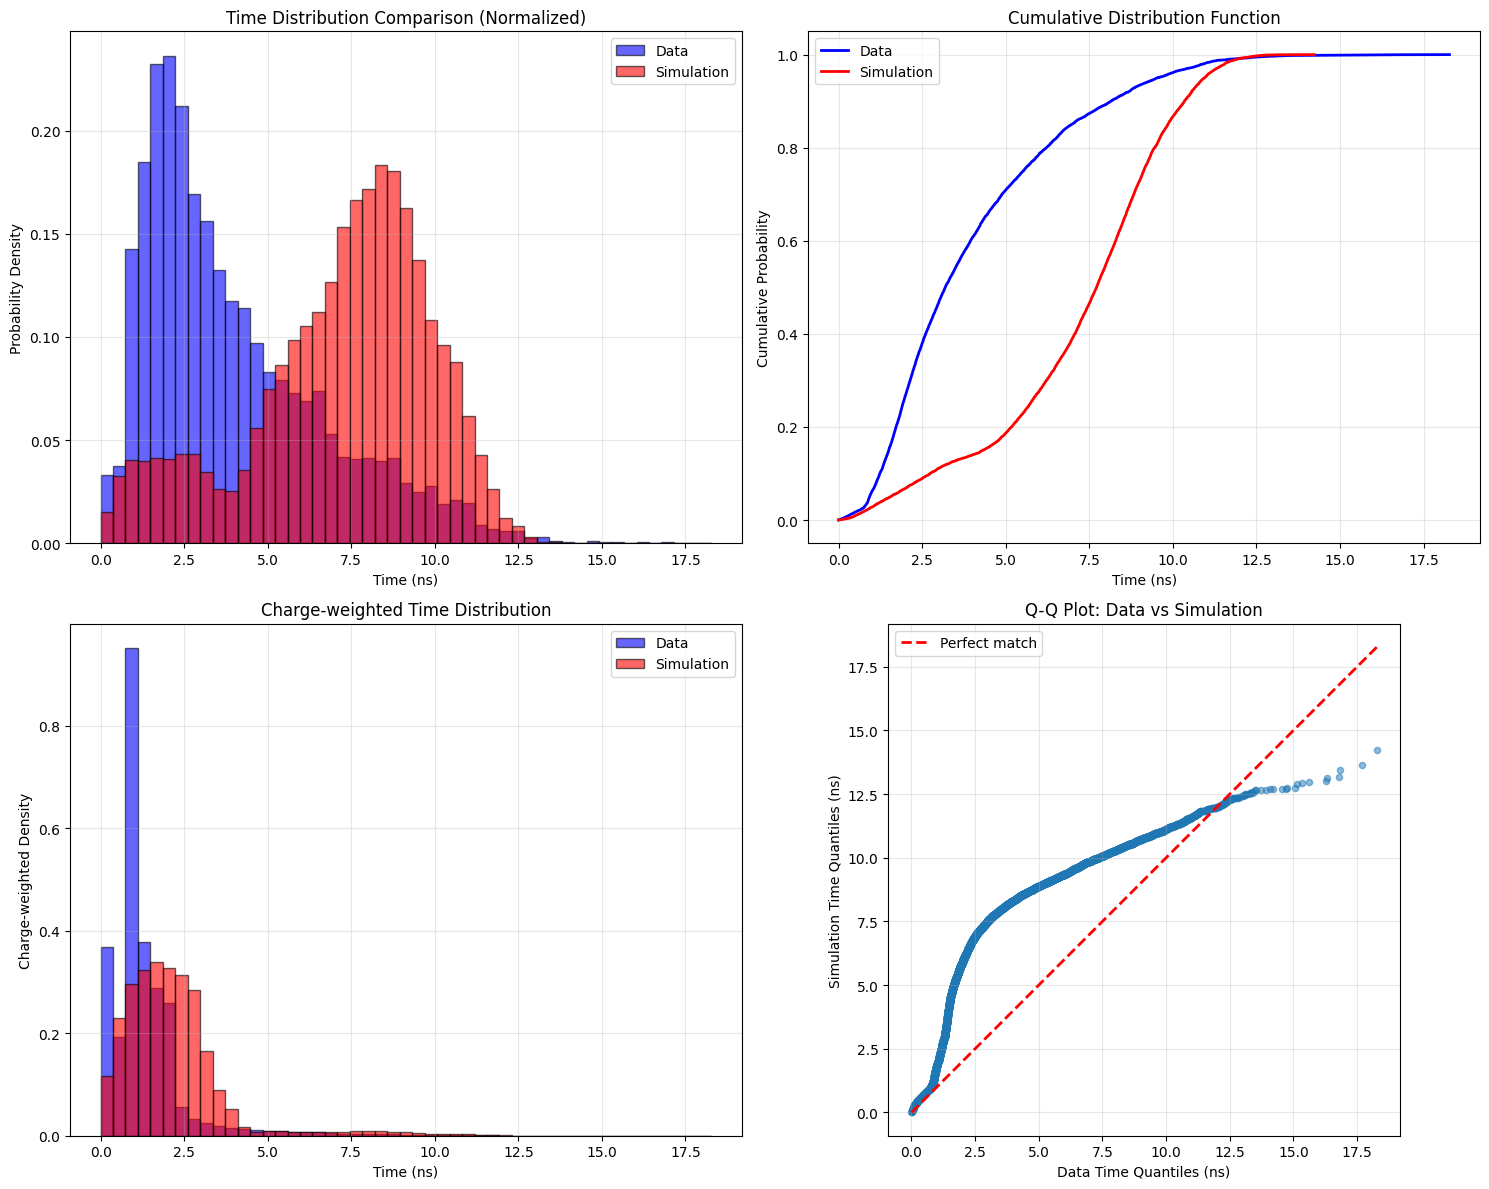

In [6]:
# Plot time distributions
if data_charges is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histogram comparison
    ax1 = axes[0, 0]
    time_bins = np.linspace(0, max(np.max(data_times_active), np.max(sim_times_active)), 50)
    
    # Plot normalized histograms
    ax1.hist(data_times_active, bins=time_bins, alpha=0.6, density=True, label='Data', color='blue', edgecolor='black')
    ax1.hist(sim_times_active, bins=time_bins, alpha=0.6, density=True, label='Simulation', color='red', edgecolor='black')
    
    ax1.set_xlabel('Time (ns)')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('Time Distribution Comparison (Normalized)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative distribution comparison
    ax2 = axes[0, 1]
    
    # Sort times for CDF
    data_times_sorted = np.sort(data_times_active)
    sim_times_sorted = np.sort(sim_times_active)
    
    # Create CDFs
    data_cdf = np.arange(1, len(data_times_sorted) + 1) / len(data_times_sorted)
    sim_cdf = np.arange(1, len(sim_times_sorted) + 1) / len(sim_times_sorted)
    
    ax2.plot(data_times_sorted, data_cdf, 'b-', linewidth=2, label='Data')
    ax2.plot(sim_times_sorted, sim_cdf, 'r-', linewidth=2, label='Simulation')
    
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Function')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Charge-weighted time distribution
    ax3 = axes[1, 0]
    
    # Create charge-weighted histograms
    ax3.hist(data_times_active, bins=time_bins, weights=data_charges_active, 
             alpha=0.6, density=True, label='Data', color='blue', edgecolor='black')
    ax3.hist(sim_times_active, bins=time_bins, weights=sim_charges_active, 
             alpha=0.6, density=True, label='Simulation', color='red', edgecolor='black')
    
    ax3.set_xlabel('Time (ns)')
    ax3.set_ylabel('Charge-weighted Density')
    ax3.set_title('Charge-weighted Time Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Q-Q plot
    ax4 = axes[1, 1]
    
    # Sample same number of points for Q-Q plot
    n_samples = min(len(data_times_active), len(sim_times_active))
    data_quantiles = np.percentile(data_times_active, np.linspace(0, 100, n_samples))
    sim_quantiles = np.percentile(sim_times_active, np.linspace(0, 100, n_samples))
    
    ax4.scatter(data_quantiles, sim_quantiles, alpha=0.5, s=20)
    
    # Add diagonal line
    min_val = min(np.min(data_quantiles), np.min(sim_quantiles))
    max_val = max(np.max(data_quantiles), np.max(sim_quantiles))
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect match')
    
    ax4.set_xlabel('Data Time Quantiles (ns)')
    ax4.set_ylabel('Simulation Time Quantiles (ns)')
    ax4.set_title('Q-Q Plot: Data vs Simulation')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

In [7]:
# Statistical tests for distribution comparison
if data_charges is not None:
    print("Statistical Tests for Time Distribution Comparison:")
    print("=" * 60)
    
    # Kolmogorov-Smirnov test
    ks_statistic, ks_pvalue = stats.ks_2samp(data_times_active, sim_times_active)
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {ks_statistic:.4f}")
    print(f"  p-value: {ks_pvalue:.4f}")
    print(f"  Interpretation: {'Distributions are similar' if ks_pvalue > 0.05 else 'Distributions differ significantly'}")
    
    # Anderson-Darling test
    try:
        ad_result = stats.anderson_ksamp([data_times_active, sim_times_active])
        print(f"\nAnderson-Darling Test:")
        print(f"  Statistic: {ad_result.statistic:.4f}")
        print(f"  Critical values: {ad_result.critical_values}")
        print(f"  Significance levels: {ad_result.significance_level}")
    except:
        print("\nAnderson-Darling test could not be performed.")
    
    # Basic statistics comparison
    print(f"\nBasic Statistics Comparison:")
    print(f"  Mean difference: {np.mean(data_times_active) - np.mean(sim_times_active):.2f} ns")
    print(f"  Std difference: {np.std(data_times_active) - np.std(sim_times_active):.2f} ns")
    print(f"  Median difference: {np.median(data_times_active) - np.median(sim_times_active):.2f} ns")
    
    # Percentile comparison
    print(f"\nPercentile Comparison:")
    percentiles = [10, 25, 50, 75, 90]
    print(f"  {'Percentile':<12} {'Data (ns)':<12} {'Sim (ns)':<12} {'Difference':<12}")
    print("  " + "-" * 48)
    for p in percentiles:
        data_p = np.percentile(data_times_active, p)
        sim_p = np.percentile(sim_times_active, p)
        diff_p = data_p - sim_p
        print(f"  {p:>10}% {data_p:>11.1f} {sim_p:>11.1f} {diff_p:>11.1f}")

Statistical Tests for Time Distribution Comparison:

Kolmogorov-Smirnov Test:
  Statistic: 0.5234
  p-value: 0.0000
  Interpretation: Distributions differ significantly

Anderson-Darling Test:
  Statistic: 3234.2060
  Critical values: [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
  Significance levels: 0.001

Basic Statistics Comparison:
  Mean difference: -3.21 ns
  Std difference: -0.01 ns
  Median difference: -4.53 ns

Percentile Comparison:
  Percentile   Data (ns)    Sim (ns)     Difference  
  ------------------------------------------------
          10%         1.2         2.7        -1.5
          25%         1.9         5.7        -3.8
          50%         3.2         7.7        -4.5
          75%         5.5         9.1        -3.6
          90%         8.1        10.3        -2.2


/lscratch/cjesus/tmp/ipykernel_2927913/3865157646.py:15: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([data_times_active, sim_times_active])



Timing Difference Statistics (for PMTs active in both):
  Number of PMTs: 8710
  Mean difference: -2.99 ns
  Std of differences: 2.57 ns
  Min difference: -10.90 ns
  Max difference: 8.99 ns


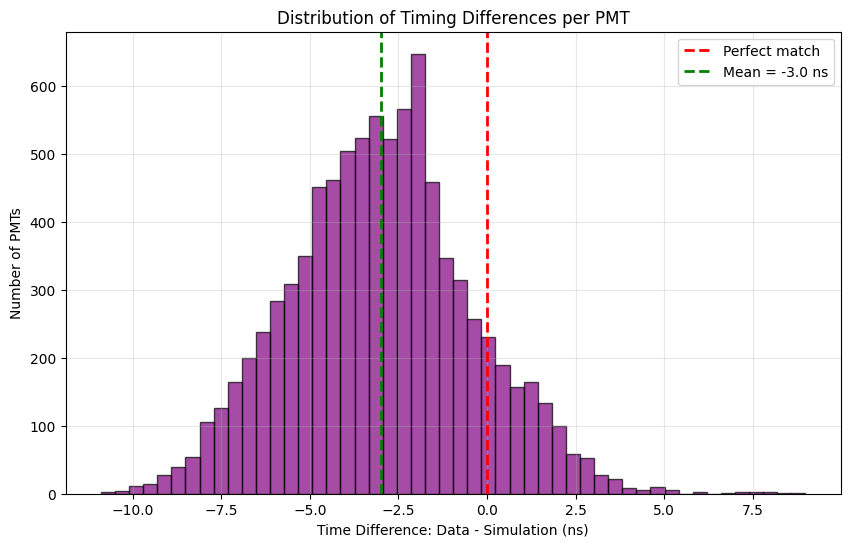

In [8]:
# Spatial distribution of timing differences
if data_charges is not None:
    # Create a map showing where timing differences occur
    time_diff_map = np.zeros(NUM_DETECTORS)
    
    # For PMTs active in both data and simulation
    both_active = active_data_mask & active_sim_mask
    time_diff_map[both_active] = data_times[both_active] - avg_sim_times[both_active]
    
    # Statistics on timing differences
    active_diffs = time_diff_map[both_active]
    print(f"\nTiming Difference Statistics (for PMTs active in both):")
    print(f"  Number of PMTs: {np.sum(both_active)}")
    print(f"  Mean difference: {np.mean(active_diffs):.2f} ns")
    print(f"  Std of differences: {np.std(active_diffs):.2f} ns")
    print(f"  Min difference: {np.min(active_diffs):.2f} ns")
    print(f"  Max difference: {np.max(active_diffs):.2f} ns")
    
    # Histogram of timing differences
    plt.figure(figsize=(10, 6))
    plt.hist(active_diffs, bins=50, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect match')
    plt.axvline(np.mean(active_diffs), color='green', linestyle='--', linewidth=2, label=f'Mean = {np.mean(active_diffs):.1f} ns')
    plt.xlabel('Time Difference: Data - Simulation (ns)')
    plt.ylabel('Number of PMTs')
    plt.title('Distribution of Timing Differences per PMT')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Creating detector visualization for time distributions...


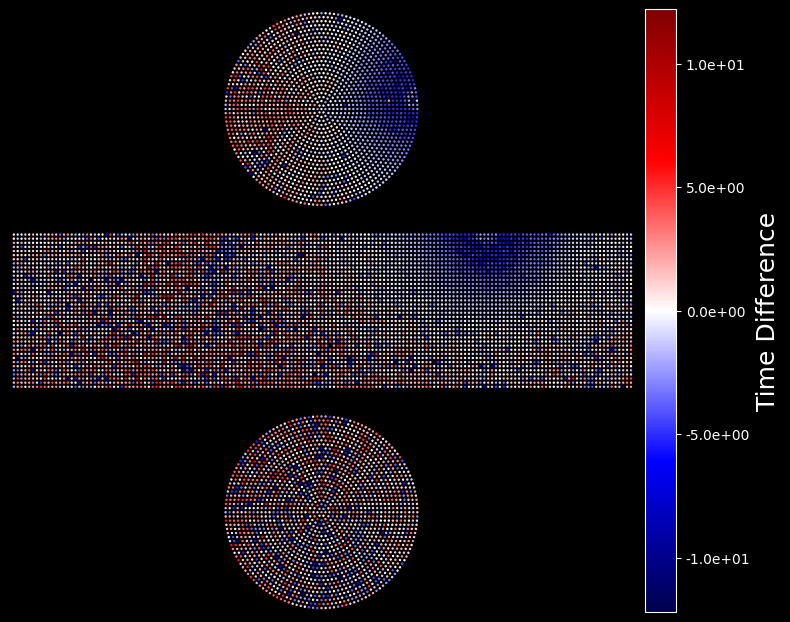

In [9]:
# Create detector displays for visual comparison
if data_charges is not None:
    print("Creating detector visualization for time distributions...")
    
    # Create comparison display function
    display_comparison = create_detector_comparison_display(json_filename, sparse=False)
    
    # Display time comparison
    display_comparison(
        true_data=(data_charges, data_times),
        sim_data=(avg_sim_charges, avg_sim_times),
        plot_time=True,
        align_time=True  # This will subtract mean from both distributions
    )

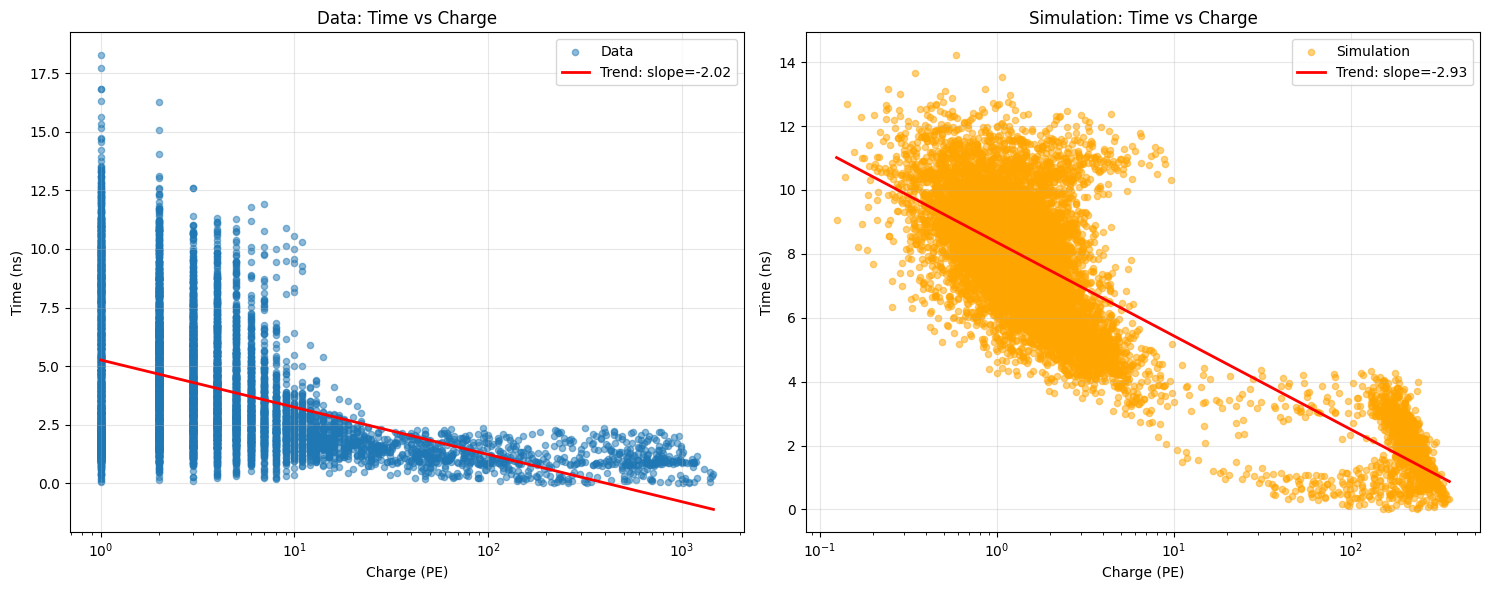


Time-Charge Correlation Analysis:
  Data correlation coefficient: -0.447
  Simulation correlation coefficient: -0.826


In [10]:
# Analyze time resolution effects
if data_charges is not None:
    # Plot time vs charge to see if there's a correlation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Data: time vs charge
    ax1.scatter(data_charges_active, data_times_active, alpha=0.5, s=20, label='Data')
    ax1.set_xlabel('Charge (PE)')
    ax1.set_ylabel('Time (ns)')
    ax1.set_title('Data: Time vs Charge')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    z1 = np.polyfit(np.log10(data_charges_active), data_times_active, 1)
    p1 = np.poly1d(z1)
    x_trend = np.logspace(np.log10(np.min(data_charges_active)), 
                         np.log10(np.max(data_charges_active)), 100)
    ax1.plot(x_trend, p1(np.log10(x_trend)), 'r-', linewidth=2, 
             label=f'Trend: slope={z1[0]:.2f}')
    ax1.legend()
    
    # Simulation: time vs charge
    ax2.scatter(sim_charges_active, sim_times_active, alpha=0.5, s=20, label='Simulation', color='orange')
    ax2.set_xlabel('Charge (PE)')
    ax2.set_ylabel('Time (ns)')
    ax2.set_title('Simulation: Time vs Charge')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Add trend line
    z2 = np.polyfit(np.log10(sim_charges_active), sim_times_active, 1)
    p2 = np.poly1d(z2)
    x_trend2 = np.logspace(np.log10(np.min(sim_charges_active)), 
                          np.log10(np.max(sim_charges_active)), 100)
    ax2.plot(x_trend2, p2(np.log10(x_trend2)), 'r-', linewidth=2, 
             label=f'Trend: slope={z2[0]:.2f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTime-Charge Correlation Analysis:")
    print(f"  Data correlation coefficient: {np.corrcoef(np.log10(data_charges_active), data_times_active)[0,1]:.3f}")
    print(f"  Simulation correlation coefficient: {np.corrcoef(np.log10(sim_charges_active), sim_times_active)[0,1]:.3f}")

In [11]:
# Summary comparison metrics
if data_charges is not None:
    print("\n" + "=" * 80)
    print("SUMMARY: TIME DISTRIBUTION COMPARISON")
    print("=" * 80)
    
    # Calculate various metrics
    mean_abs_diff = np.mean(np.abs(active_diffs))
    rms_diff = np.sqrt(np.mean(active_diffs**2))
    
    # Wasserstein distance (Earth Mover's Distance)
    wasserstein_dist = stats.wasserstein_distance(data_times_active, sim_times_active)
    
    print(f"\nOverall Metrics:")
    print(f"  Mean Absolute Difference: {mean_abs_diff:.2f} ns")
    print(f"  RMS Difference: {rms_diff:.2f} ns")
    print(f"  Wasserstein Distance: {wasserstein_dist:.2f} ns")
    print(f"  KS Test p-value: {ks_pvalue:.4f}")
    
    # PMT coverage comparison
    print(f"\nPMT Coverage:")
    print(f"  Data PMTs with signal: {np.sum(active_data_mask)} ({100*np.sum(active_data_mask)/NUM_DETECTORS:.1f}%)")
    print(f"  Sim PMTs with signal: {np.sum(active_sim_mask)} ({100*np.sum(active_sim_mask)/NUM_DETECTORS:.1f}%)")
    print(f"  PMTs active in both: {np.sum(both_active)} ({100*np.sum(both_active)/NUM_DETECTORS:.1f}%)")
    print(f"  PMTs only in data: {np.sum(active_data_mask & ~active_sim_mask)}")
    print(f"  PMTs only in sim: {np.sum(~active_data_mask & active_sim_mask)}")
    
    # Time range comparison
    print(f"\nTime Range:")
    print(f"  Data: [{np.min(data_times_active):.1f}, {np.max(data_times_active):.1f}] ns")
    print(f"  Simulation: [{np.min(sim_times_active):.1f}, {np.max(sim_times_active):.1f}] ns")
    
    print("\n" + "=" * 80)


SUMMARY: TIME DISTRIBUTION COMPARISON

Overall Metrics:
  Mean Absolute Difference: 3.34 ns
  RMS Difference: 3.94 ns
  Wasserstein Distance: 3.23 ns
  KS Test p-value: 0.0000

PMT Coverage:
  Data PMTs with signal: 8711 (89.6%)
  Sim PMTs with signal: 9719 (100.0%)
  PMTs active in both: 8710 (89.6%)
  PMTs only in data: 1
  PMTs only in sim: 1009

Time Range:
  Data: [0.0, 18.3] ns
  Simulation: [0.0, 14.2] ns



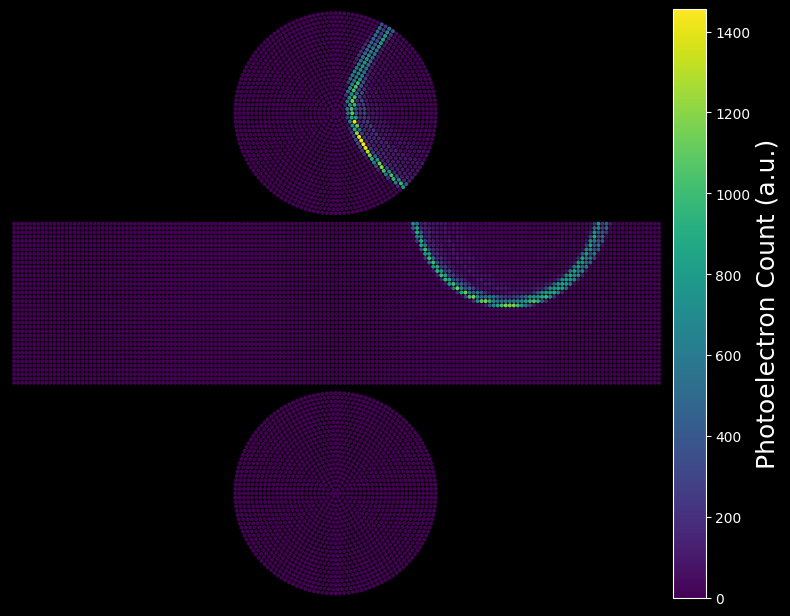

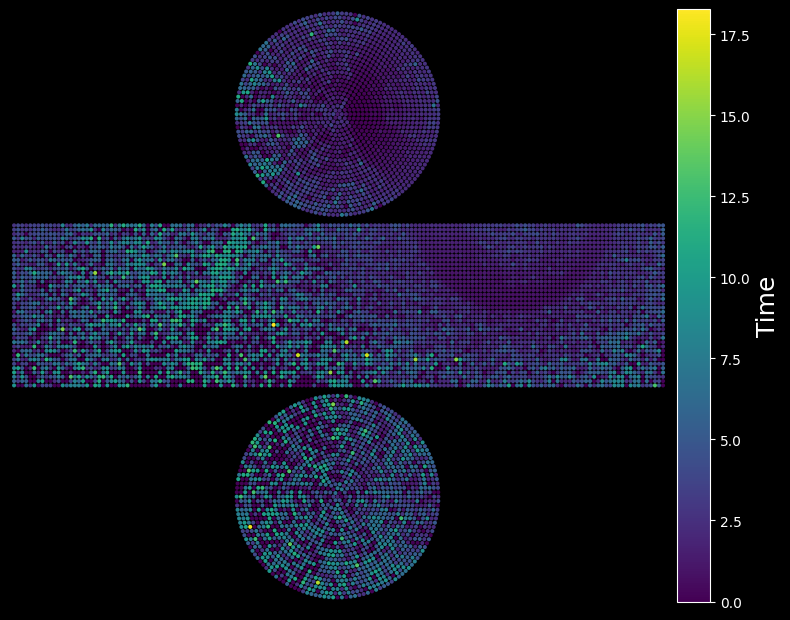

In [12]:
from tools.visualization import create_detector_display
# Create visualization
detector_display = create_detector_display(json_filename, sparse=False)

# Display charge pattern
detector_display(data_charges, data_times, 
                file_name=None,
                plot_time=False, log_scale=False)

# Display time pattern
detector_display(data_charges, data_times, 
                file_name=None, 
                plot_time=True, log_scale=False)

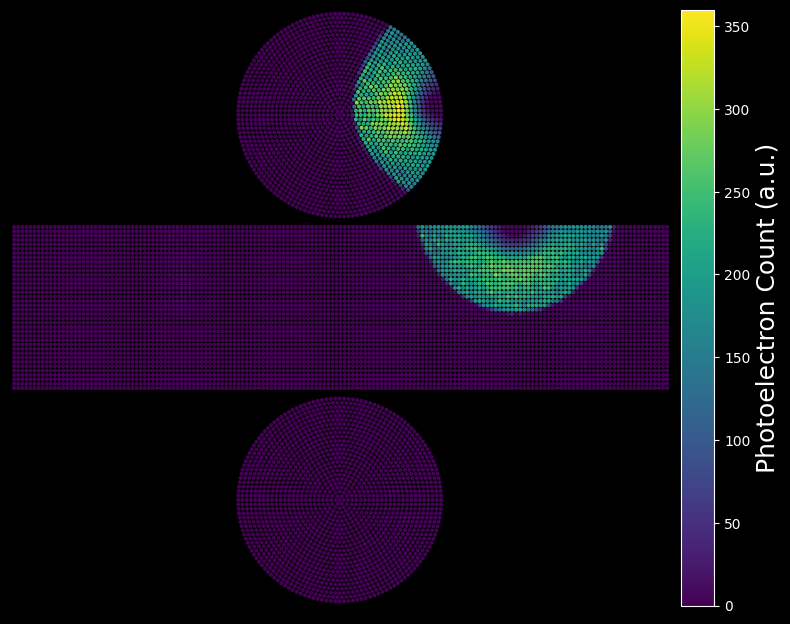

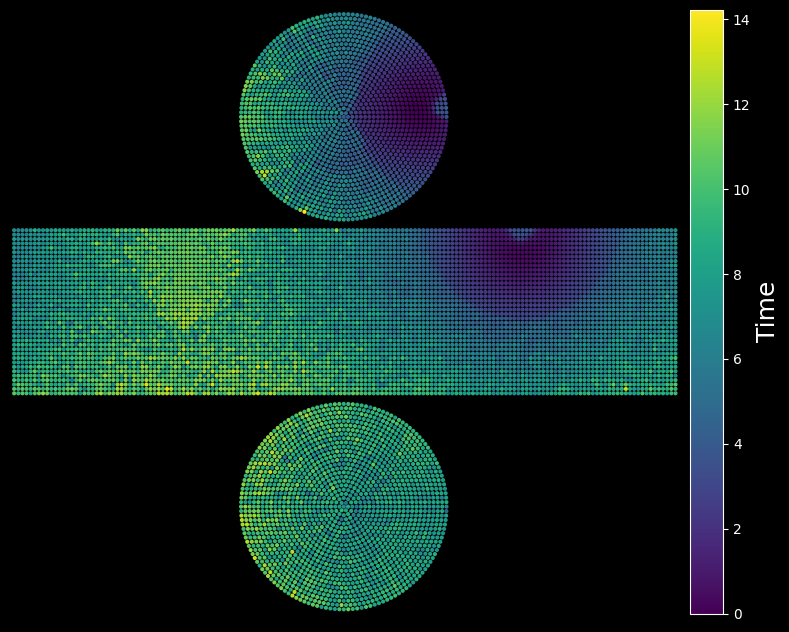

In [13]:
from tools.visualization import create_detector_display
# Create visualization
detector_display = create_detector_display(json_filename, sparse=False)

# Display charge pattern
detector_display(avg_sim_charges, avg_sim_times, 
                file_name=None,
                plot_time=False, log_scale=False)

# Display time pattern
detector_display(avg_sim_charges, avg_sim_times, 
                file_name=None, 
                plot_time=True, log_scale=False)

(array([  0., 167.,  79.,  39.,  32.,  21.,  18.,  16.,  21.,  15.,  26.,
         20.,  17.,  18.,  15.,  19.,  11.,   9.,   7.,  11.,   8.,   3.,
          7.,   3.,   2.,   1.,   0.,   2.,   2.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
        1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700., 1750.,
        1800., 1850., 1900., 1950., 2000., 2050., 2100., 2150., 2200.,
        2250., 2300., 2350., 2400., 2450., 2500.]),
 <BarContainer object of 50 artists>)

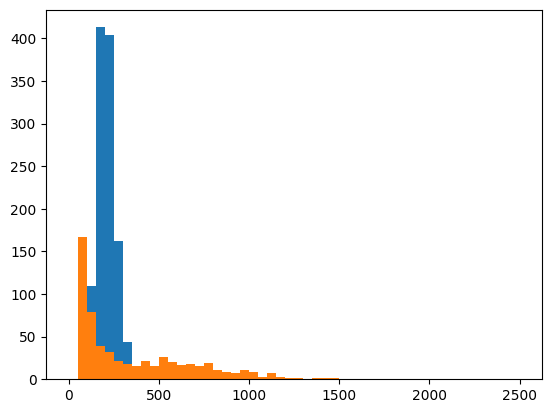

In [28]:
min_charge_mask = avg_sim_charges > 50.
plt.hist(avg_sim_charges[min_charge_mask], bins=50, range=[0,2500])


min_charge_data_mask = data_charges > 50.
plt.hist(data_charges[min_charge_data_mask], bins=50, range=[0,2500])

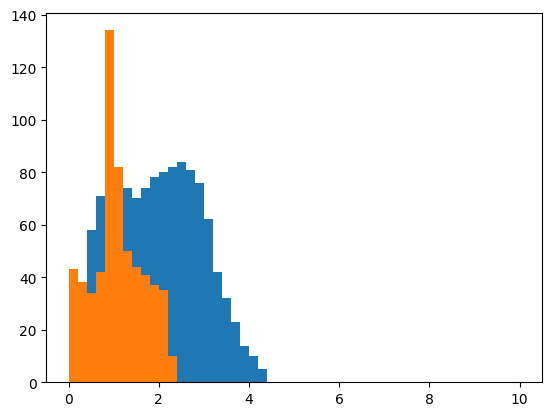

In [36]:
min_charge_mask = avg_sim_charges > 50.
_ = plt.hist(avg_sim_times[min_charge_mask], bins=50, range=[0,10])

min_charge_data_mask = data_charges > 50.
_ = plt.hist(data_times[min_charge_data_mask], bins=50, range=[0,10])